In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.signal import savgol_filter, butter, lfilter, freqz

In [81]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='serif')
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE, facecolor='white')

In [5]:
data = pkl.load(open('./weather_data_24hrchunks_2012_to_2017.pkl','rb'))

In [8]:
keynames = ['span_days', 
'hour_per_chunk',
'typ_len', 
'abs_temp', 
'f_resample', 
'Pxx_avg']

In [51]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

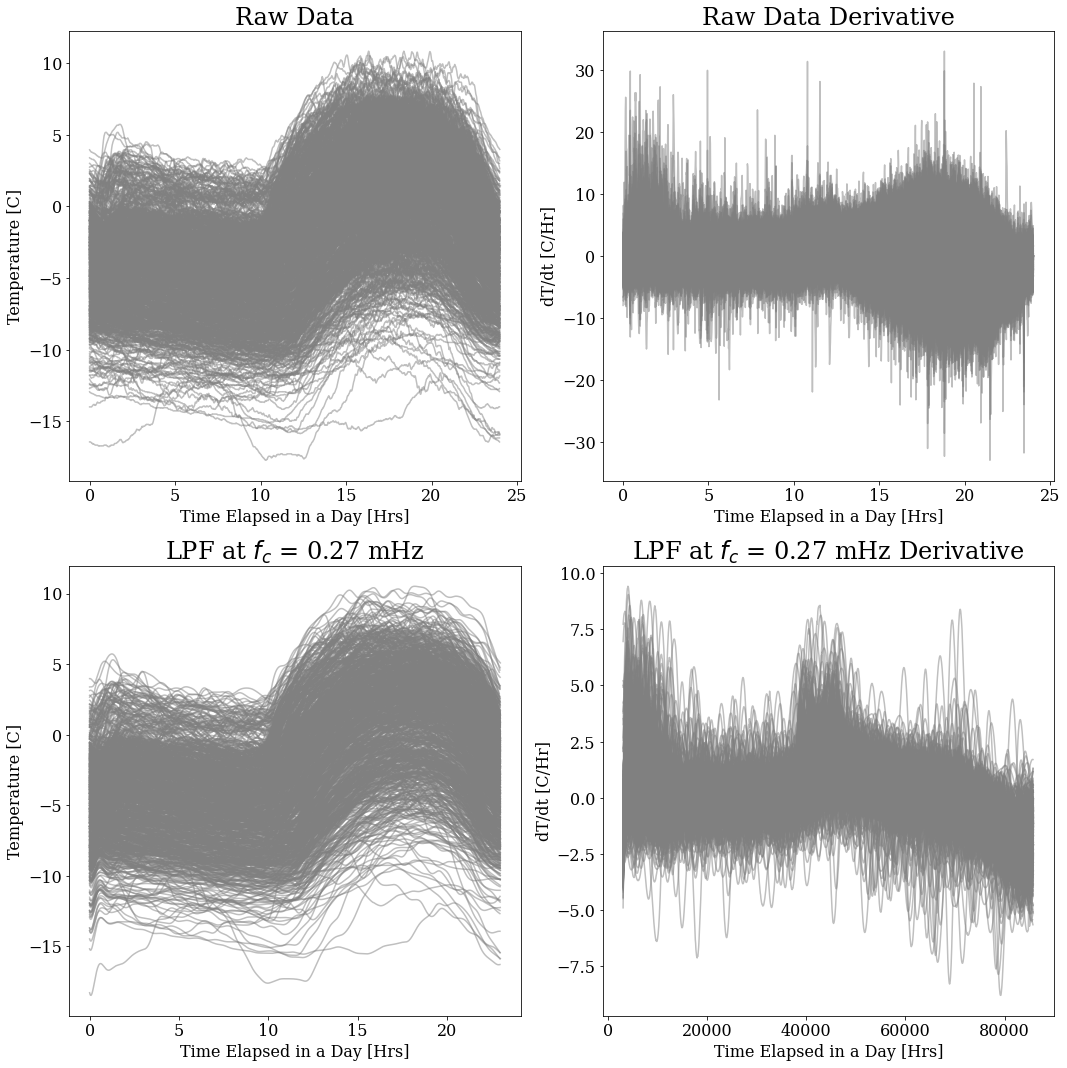

In [89]:
peak_to_peak_temp = []
avg_temp = []
min_temp = []
max_temp = []
all_temps = np.zeros(0)

peak_to_peak_deriv_raw = []
avg_deriv_raw = []
min_deriv_raw = []
max_deriv_raw = []
all_deriv_raw = np.zeros(0)

peak_to_peak_deriv_filt = []
avg_deriv_filt = []
min_deriv_filt = []
max_deriv_filt = []
all_deriv_filt = np.zeros(0)

fig, axes = plt.subplots(2,2,figsize = (15,15))
ax = axes.flatten()
for i in range(2044):
    if not(data[i]['bad_flag']):
        peak_to_peak_temp.append(np.ptp(data[i]['abs_temp']))
        all_temps = np.concatenate((all_temps, data[i]['abs_temp']))
        avg_temp.append(np.mean(data[i]['abs_temp']))
        min_temp.append(np.min(data[i]['abs_temp']))
        max_temp.append(np.max(data[i]['abs_temp']))
        fs = 1/np.mean(np.diff(data[i]['rel_t']))
        # print(fs)
        data_lpf = butter_lowpass_filter(data[i]['abs_temp'],0.00027,fs,4)[50:-10]
        t = data[i]['rel_t'][50:-10]
        dTdt_raw =  np.diff(data[i]['abs_temp'])/np.diff((data[i]['rel_t']-data[i]['rel_t'][0])/60/60)
        dTdt_filt = np.diff(data_lpf)/np.diff((t-t[0])/60/60)
        
        peak_to_peak_deriv_raw.append(np.ptp(dTdt_raw))
        all_deriv_raw = np.concatenate((all_deriv_raw, dTdt_raw))
        avg_deriv_raw.append(np.mean(dTdt_raw))
        min_deriv_raw.append(np.min(dTdt_raw))
        max_deriv_raw.append(np.max(dTdt_raw))
        
        peak_to_peak_deriv_filt.append(np.ptp(dTdt_filt))
        all_deriv_filt = np.concatenate((all_deriv_filt, dTdt_filt))
        avg_deriv_filt.append(np.mean(dTdt_filt))
        min_deriv_filt.append(np.min(dTdt_filt))
        max_deriv_filt.append(np.max(dTdt_filt))
        
        fs = 1/np.mean(np.diff(data[i]['rel_t']))        
        
        ax[0].plot((data[i]['rel_t']-data[i]['rel_t'][0])/60/60,
                   data[i]['abs_temp'],
                 color = 'grey', alpha = 0.5)
        ax[1].plot(data[i]['rel_t'][1:]/60/60,
                 np.diff(data[i]['abs_temp'])/np.diff((data[i]['rel_t']-data[i]['rel_t'][0])/60/60),
                 color = 'grey', alpha = 0.5)
        ax[2].plot((t-t[0])/60/60,
                   data_lpf,
                 color = 'grey', alpha = 0.5)
        ax[3].plot(t[1:]-t[0]/60/60,
                 np.diff(data_lpf)/np.diff((t-t[0])/60/60),
                 color = 'grey', alpha = 0.5)
ax[0].set_xlabel('Time Elapsed in a Day [Hrs]',fontsize = 16)
ax[0].set_ylabel('Temperature [C]',fontsize = 16)
ax[0].set_title('Raw Data',fontsize = 24)
ax[1].set_xlabel('Time Elapsed in a Day [Hrs]',fontsize = 16)
ax[1].set_ylabel('dT/dt [C/Hr]',fontsize = 16)
ax[1].set_title('Raw Data Derivative',fontsize = 24)
ax[2].set_xlabel('Time Elapsed in a Day [Hrs]',fontsize = 16)
ax[2].set_ylabel('Temperature [C]',fontsize = 16)
ax[2].set_title('LPF at $f_c$ = 0.27 mHz',fontsize = 24)
ax[3].set_xlabel('Time Elapsed in a Day [Hrs]',fontsize = 16)
ax[3].set_ylabel('dT/dt [C/Hr]',fontsize = 16)
ax[3].set_title('LPF at $f_c$ = 0.27 mHz Derivative',fontsize = 24)
plt.tight_layout()

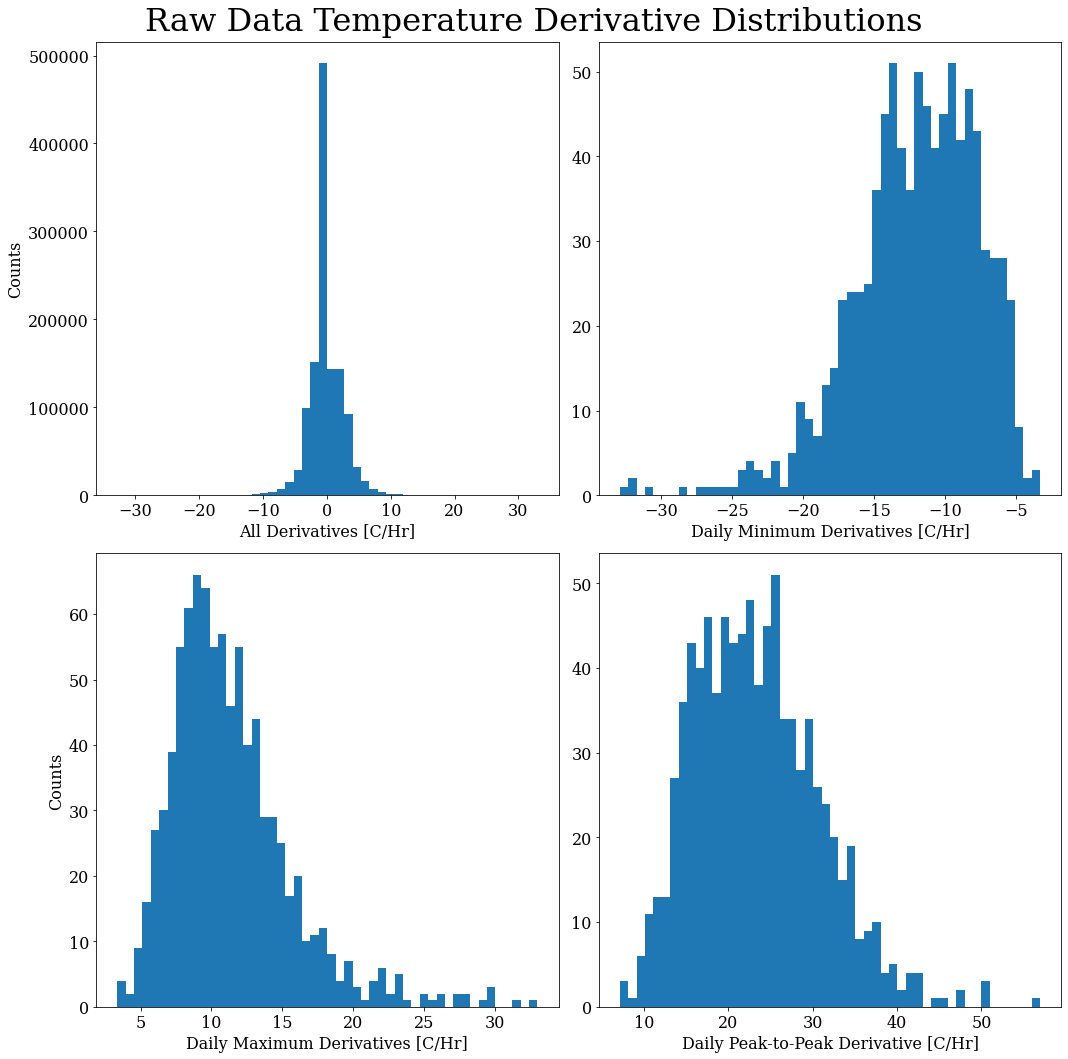

In [93]:
fig, axes = plt.subplots(2,2,figsize = (15,15))
ax = axes.flatten()
ax[0].hist(all_deriv_raw, bins = 50)
ax[0].set_xlabel('All Derivatives [C/Hr]')
ax[0].set_ylabel('Counts')
ax[1].hist(min_deriv_raw, bins =50)
ax[1].set_xlabel('Daily Minimum Derivatives [C/Hr]')
ax[2].hist(max_deriv_raw, bins = 50)
ax[2].set_xlabel('Daily Maximum Derivatives [C/Hr]')
ax[2].set_ylabel('Counts',fontsize = 16)
_ = ax[3].hist(peak_to_peak_deriv_raw, bins =50)
ax[3].set_xlabel('Daily Peak-to-Peak Derivative [C/Hr]')
plt.suptitle('Raw Data Temperature Derivative Distributions',fontsize = 32)
plt.tight_layout()

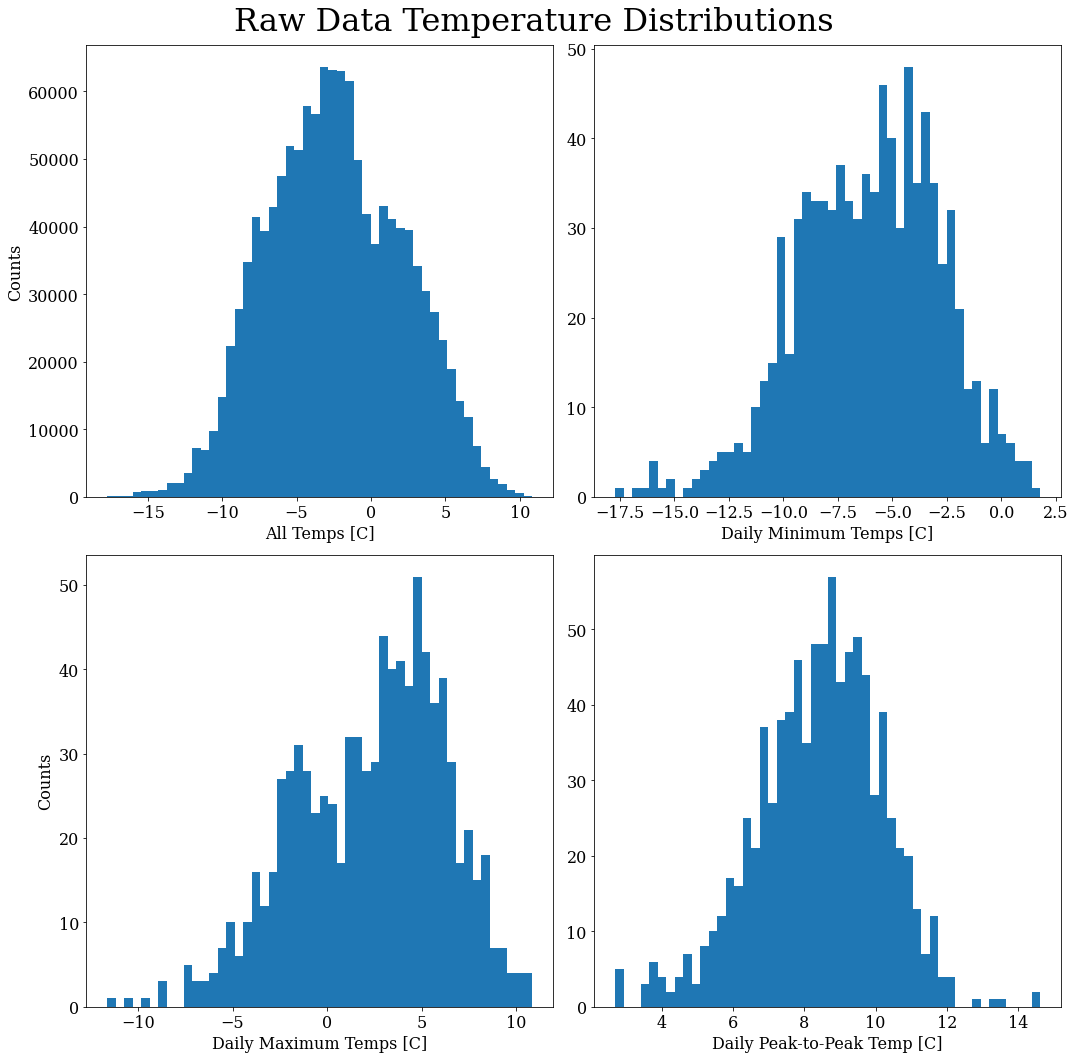

In [91]:
fig, axes = plt.subplots(2,2,figsize = (15,15))
ax = axes.flatten()
ax[0].hist(all_temps, bins = 50)
ax[0].set_xlabel('All Temps [C]')
ax[0].set_ylabel('Counts')
ax[1].hist(min_temp, bins =50)
ax[1].set_xlabel('Daily Minimum Temps [C]')
ax[2].hist(max_temp, bins = 50)
ax[2].set_xlabel('Daily Maximum Temps [C]')
ax[2].set_ylabel('Counts',fontsize = 16)
_ = ax[3].hist(peak_to_peak_temp, bins =50)
ax[3].set_xlabel('Daily Peak-to-Peak Temp [C]')
plt.suptitle('Raw Data Temperature Distributions',fontsize = 32)
plt.tight_layout()

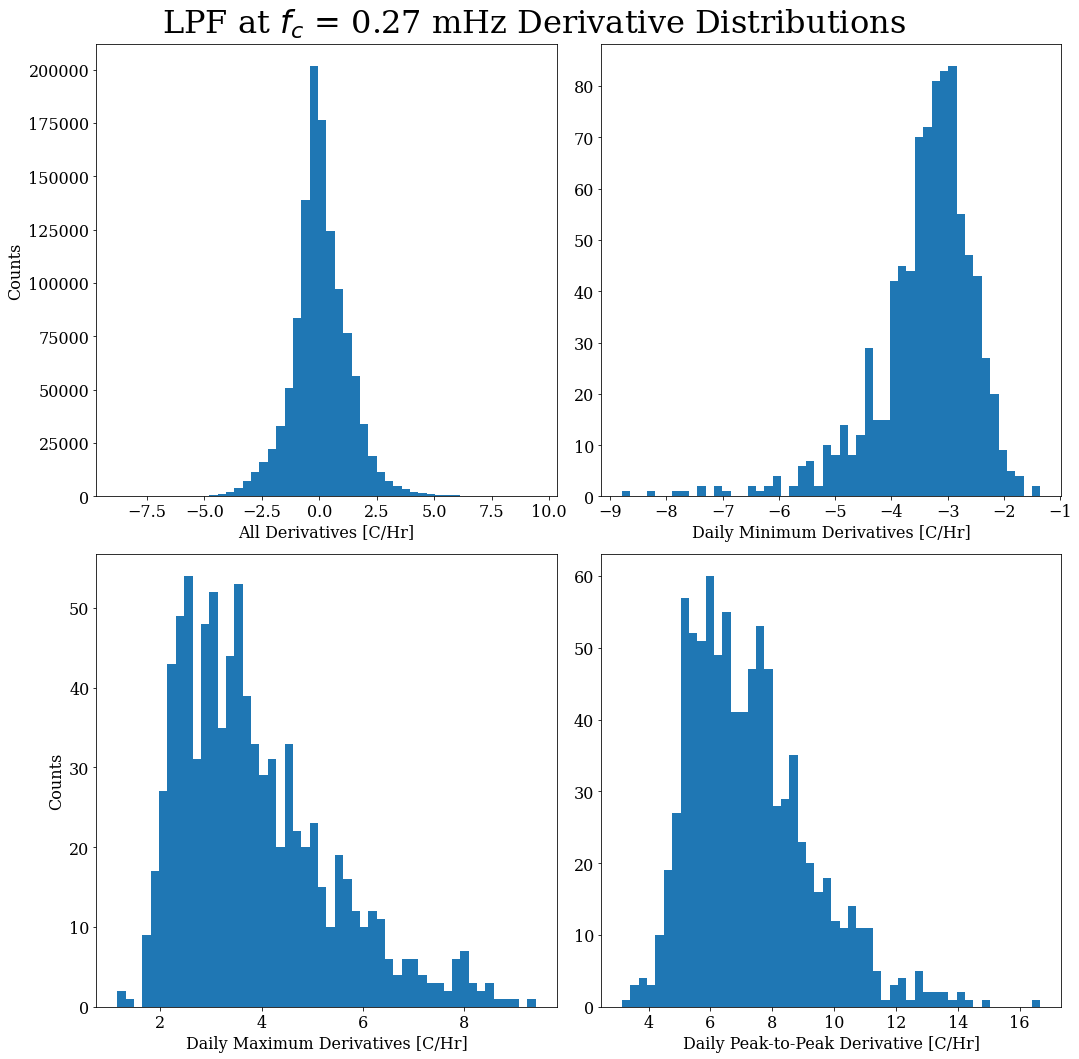

In [94]:
fig, axes = plt.subplots(2,2,figsize = (15,15))
ax = axes.flatten()
ax[0].hist(all_deriv_filt, bins = 50)
ax[0].set_xlabel('All Derivatives [C/Hr]')
ax[0].set_ylabel('Counts')
ax[1].hist(min_deriv_filt, bins =50)
ax[1].set_xlabel('Daily Minimum Derivatives [C/Hr]')
ax[2].hist(max_deriv_filt, bins = 50)
ax[2].set_xlabel('Daily Maximum Derivatives [C/Hr]')
ax[2].set_ylabel('Counts',fontsize = 16)
_ = ax[3].hist(peak_to_peak_deriv_filt, bins =50)
ax[3].set_xlabel('Daily Peak-to-Peak Derivative [C/Hr]')
plt.suptitle('LPF at $f_c$ = 0.27 mHz Derivative Distributions',fontsize = 32)
plt.tight_layout()